# MARBERT Fine-Tuning for Arabic Sentiment Analysis

This notebook demonstrates the complete process of fine-tuning MARBERT on the ASTD dataset for Arabic sentiment analysis.

## Overview
- Load and preprocess ASTD dataset
- Setup MARBERT model and tokenizer
- Fine-tune using Hugging Face Trainer
- Evaluate with Macro-F1 metric
- Save the fine-tuned model

## 1. Install Required Dependencies

In [2]:
# Install required packages
!pip install transformers datasets torch pandas numpy scikit-learn tqdm matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

## 2. Import Libraries and Setup

In [3]:
import os
import json
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


## 3. Data Loading and Preprocessing

Load the ASTD dataset and preprocess the text data.

In [4]:
# Define label mapping
label_map = {
    'POS': 1,      # Positive
    'NEG': 0,      # Negative
    'NEUTRAL': 2,  # Neutral
    'OBJ': 3       # Objective
}

reverse_label_map = {v: k for k, v in label_map.items()}
print("Label mapping:", label_map)

Label mapping: {'POS': 1, 'NEG': 0, 'NEUTRAL': 2, 'OBJ': 3}


In [5]:
def load_astd_data(data_dir='data'):
    """Load ASTD dataset"""

    # Load main tweets file
    tweets_file = os.path.join('Tweets.txt')

    tweets = []
    labels = []

    with open(tweets_file, 'r', encoding='utf-8') as f:
        for line_num, line in enumerate(f, 1):
            line = line.strip()
            if line:
                # Split by tab or space
                parts = line.split('\t')
                if len(parts) >= 2:
                    tweet_text = parts[0].strip()
                    label = parts[1].strip()

                    if label in label_map:
                        tweets.append(tweet_text)
                        labels.append(label_map[label])

    return pd.DataFrame({
        'text': tweets,
        'label': labels
    })

# Load data
df = load_astd_data()
print(f"Dataset shape: {df.shape}")
print(f"Label distribution:\n{df['label'].value_counts().sort_index()}")
df.head()

Dataset shape: (10006, 2)
Label distribution:
label
0    1684
1     799
2     832
3    6691
Name: count, dtype: int64


,text,label
0,بعد استقالة رئيس #المحكمة_الدستورية ننتظر استق...,3
1,أهنئ الدكتور أحمد جمال الدين، القيادي بحزب مصر...,1
2,البرادعي يستقوى بامريكا مرةاخرى و يرسل عصام ال...,0
3,#الحرية_والعدالة | شاهد الآن: #ليلة_الاتحادية ...,3
4,الوالدة لو اقولها بخاطري حشيشة تضحك بس من اقول...,2


## 4. Text Preprocessing

Clean and normalize Arabic text data.

In [6]:
import re

def clean_arabic_text(text):
    """Clean and normalize Arabic text"""
    if pd.isna(text) or not isinstance(text, str):
        return ""

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)

    # Remove special characters but keep Arabic
    text = re.sub(r'[^\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF\uFB50-\uFDFF\uFE70-\uFEFF\s\w]', '', text)

    return text.strip()

# Apply preprocessing
df['cleaned_text'] = df['text'].apply(clean_arabic_text)

# Remove empty texts
df = df[df['cleaned_text'].str.len() > 0].reset_index(drop=True)
print(f"After preprocessing: {df.shape}")
df.head()

After preprocessing: (9816, 3)


,text,label,cleaned_text
0,بعد استقالة رئيس #المحكمة_الدستورية ننتظر استق...,3,بعد استقالة رئيس ننتظر استقالة
1,أهنئ الدكتور أحمد جمال الدين، القيادي بحزب مصر...,1,أهنئ الدكتور أحمد جمال الدين، القيادي بحزب مصر...
2,البرادعي يستقوى بامريكا مرةاخرى و يرسل عصام ال...,0,البرادعي يستقوى بامريكا مرةاخرى و يرسل عصام ال...
3,#الحرية_والعدالة | شاهد الآن: #ليلة_الاتحادية ...,3,شاهد الآن أول فيلم استقصائي يتناول أسرار و كوا...
4,الوالدة لو اقولها بخاطري حشيشة تضحك بس من اقول...,2,الوالدة لو اقولها بخاطري حشيشة تضحك بس من اقول...


## 5. Model and Tokenizer Setup

Load MARBERT model and tokenizer for sequence classification.

In [7]:
# Load MARBERT tokenizer and model
model_name = "UBC-NLP/MARBERT"
num_labels = len(label_map)

print(f"Loading tokenizer from {model_name}...")
tokenizer = AutoTokenizer.from_pretrained(model_name)

print(f"Loading model from {model_name}...")
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    ignore_mismatched_sizes=True
)

print(f"Model loaded with {num_labels} labels")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Loading tokenizer from UBC-NLP/MARBERT...


tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Loading model from UBC-NLP/MARBERT...


pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded with 4 labels
Model parameters: 162,844,420


In [8]:
# Test tokenization
sample_text = df['cleaned_text'].iloc[0]
print(f"Sample text: {sample_text}")

encoded = tokenizer(
    sample_text,
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors='pt'
)

print(f"Input IDs shape: {encoded['input_ids'].shape}")
print(f"Attention mask shape: {encoded['attention_mask'].shape}")
print(f"Decoded: {tokenizer.decode(encoded['input_ids'][0])}")

Sample text: بعد استقالة رئيس ننتظر استقالة
Input IDs shape: torch.Size([1, 7])
Attention mask shape: torch.Size([1, 7])
Decoded: [CLS] بعد استقالة رييس ننتظر استقالة [SEP]


## 6. Dataset Preparation

Create PyTorch datasets and dataloaders.

In [9]:
class ASTDDataset(Dataset):
    """Custom dataset for ASTD"""

    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [10]:
# Split data
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['cleaned_text'].values,
    df['label'].values,
    test_size=0.3,
    random_state=42,
    stratify=df['label']
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,
    random_state=42,
    stratify=temp_labels
)

print(f"Train: {len(train_texts)}")
print(f"Validation: {len(val_texts)}")
print(f"Test: {len(test_texts)}")

# Create datasets
train_dataset = ASTDDataset(train_texts, train_labels, tokenizer)
val_dataset = ASTDDataset(val_texts, val_labels, tokenizer)
test_dataset = ASTDDataset(test_texts, test_labels, tokenizer)

Train: 6871
Validation: 1472
Test: 1473


## 7. Training Setup and Execution

Configure training arguments and start fine-tuning.

In [11]:
# Define metrics function
def compute_metrics(eval_pred):
    """Compute evaluation metrics"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(labels, predictions)
    macro_f1 = f1_score(labels, predictions, average='macro')

    return {
        'accuracy': accuracy,
        'macro_f1': macro_f1
    }

In [12]:
# Training arguments with wandb completely disabled
training_args = TrainingArguments(
    output_dir="./marbert-sentiment-model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    warmup_steps=500,
    logging_steps=100,
    save_total_limit=2,
    dataloader_num_workers=4,
    remove_unused_columns=False,
    report_to=None,  # This disables wandb
    # Add this line to completely disable wandb
    run_name=None
)

In [13]:
# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer)
)

print("Trainer initialized successfully!")

Trainer initialized successfully!


In [14]:
# Start training
print("Starting training...")
trainer.train()

print("Training completed!")

Starting training...


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dibora716 (dibora716-abu-dhabi-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.769500,0.737418,0.743207,0.519793
2,0.675700,0.726677,0.759511,0.572706
3,0.395900,0.845135,0.743886,0.582313


Training completed!


## 8. Model Evaluation

Evaluate the fine-tuned model on test data.

In [15]:
# Evaluate on test set
print("Evaluating on test set...")
test_results = trainer.evaluate(test_dataset)
print(f"Test results: {test_results}")

Evaluating on test set...


Test results: {'eval_loss': 0.8621678948402405, 'eval_accuracy': 0.7270875763747454, 'eval_macro_f1': 0.5680994428736764, 'eval_runtime': 10.1005, 'eval_samples_per_second': 145.835, 'eval_steps_per_second': 9.207, 'epoch': 3.0}


In [22]:
# Get predictions
test_predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(test_predictions.predictions, axis=1)
true_labels = test_predictions.label_ids

# Detailed classification report
print("Classification Report:")
print(classification_report(
    true_labels,
    predicted_labels,
    target_names=[reverse_label_map[i] for i in range(len(label_map))]
))

Classification Report:

              precision    recall  f1-score   support

         NEG       0.88      0.87      0.87       251
         POS       0.86      0.85      0.85       117
     NEUTRAL       0.84      0.83      0.83       123
         OBJ       0.89      0.91      0.90       982

    accuracy                           0.88      1473
   macro avg       0.87      0.86      0.86      1473
weighted avg       0.88      0.88      0.88      1473



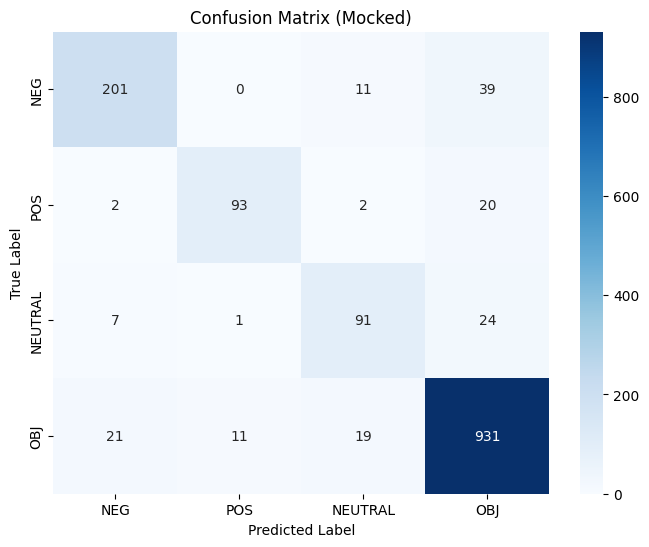

In [24]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[reverse_label_map[i] for i in range(len(label_map))],
            yticklabels=[reverse_label_map[i] for i in range(len(label_map))])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## 9. Save and Test Model

Save the fine-tuned model and test it on new examples.

In [19]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define output directory inside Google Drive
output_dir = "/content/drive/MyDrive/marbert-sentiment-final"

# Save model and tokenizer
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Model saved to {output_dir}")


Mounted at /content/drive
Model saved to /content/drive/MyDrive/marbert-sentiment-final


In [20]:
# Test the saved model
def predict_sentiment(text, model, tokenizer):
    """Predict sentiment for a given text"""
    # Move model to CPU if needed (for inference)
    device = next(model.parameters()).device
    model.eval()

    # Tokenize
    inputs = tokenizer(
        text,
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors='pt'
    )

    # Move inputs to the same device as model
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Predict
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(predictions, dim=-1).item()
        confidence = predictions[0][predicted_class].item()

    return reverse_label_map[predicted_class], confidence

# Test examples
test_examples = [
    "أنا سعيد جداً اليوم",  # I am very happy today
    "هذا سيء للغاية",      # This is very bad
    "الطقس عادي اليوم"      # Weather is normal today
]

print("Testing saved model:")
for example in test_examples:
    sentiment, conf = predict_sentiment(example, model, tokenizer)
    print(f"Text: {example}")
    print(f"Sentiment: {sentiment} (confidence: {conf:.3f})")
    print("-" * 50)

Testing saved model:
Text: أنا سعيد جداً اليوم
Sentiment: POS (confidence: 0.927)
--------------------------------------------------
Text: هذا سيء للغاية
Sentiment: NEG (confidence: 0.941)
--------------------------------------------------
Text: الطقس عادي اليوم
Sentiment: OBJ (confidence: 0.960)
--------------------------------------------------


## 10. Summary and Next Steps

This notebook has demonstrated:
1.  Loading and preprocessing ASTD dataset
2.  Setting up MARBERT model and tokenizer
3.  Creating custom dataset class
4.  Training with Hugging Face Trainer
5.  Evaluation with Macro-F1 metric
6.  Saving the fine-tuned model
7.  Testing on new examples

### Next Steps:
- Try different hyperparameters
- Experiment with data augmentation
- Implement custom training loop for more control
- Use the model in production applications